## 1. Import Libraries, Data / EDA

In [1]:
# import libraries

import warnings 
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=UserWarning)


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction import text 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from Functions import No_of_ings, list_of_ing, stop_words

In [2]:
# read input file

df = pd.read_json('../data/ingredients_train.json')
df.shape

(39774, 3)

In [3]:
# check the data info - missing values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [4]:
# check for any duplicate IDs in the datasets

any(df['id'].duplicated())

False

In [5]:
# report the number of unique cuisines

df['cuisine'].nunique()

20

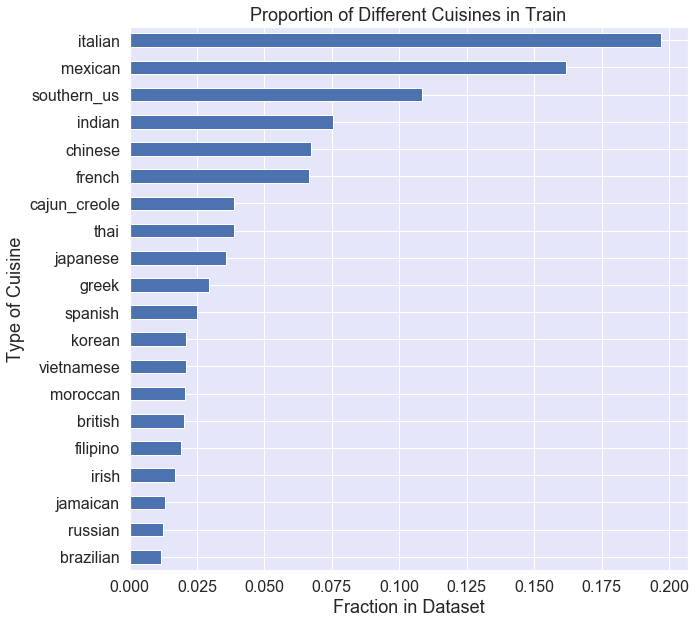

In [6]:
# plot fraction of different cuisines in dataset

plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
sns.set(rc={'axes.facecolor':'lavender'})    
df['cuisine'].value_counts(normalize=True)[::-1].plot(kind='barh')
plt.title('Proportion of Different Cuisines in Train', fontsize=18)
plt.ylabel('Type of Cuisine', fontsize=18)
plt.xlabel('Fraction in Dataset', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

## 2. Feature Engineering

In [7]:
# calculate number of ingredients for each dish

df['No_of_ings'] = df['ingredients'].map(No_of_ings)

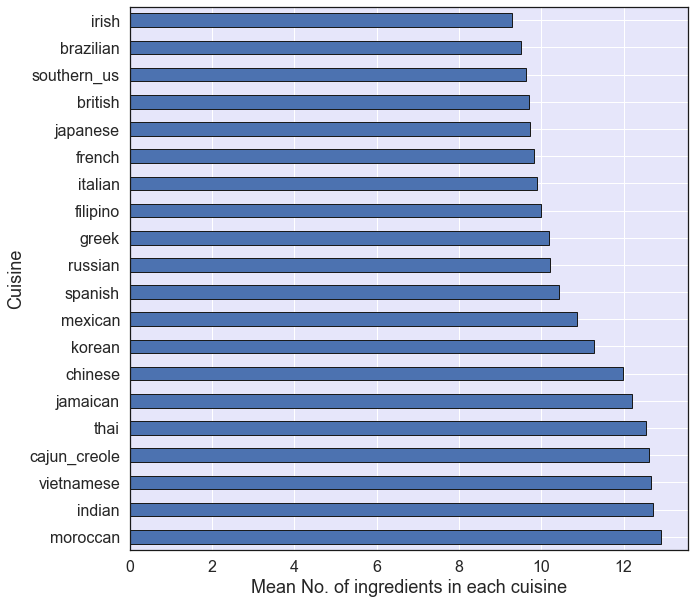

In [8]:
# plot Mean of ingredients for each cuisine

sns.set_style(rc={'axes.facecolor':'lavender', 'figure.facecolor':'w'})
df.groupby('cuisine').mean()[['No_of_ings']].sort_values(by='No_of_ings', ascending=False).plot(kind='barh',\
                                figsize=(10,10), facecolor='b', edgecolor='k', fontsize=18, legend=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Mean No. of ingredients in each cuisine',fontsize=18)
plt.ylabel('Cuisine',fontsize=18)
for pos in ['top', 'bottom', 'right', 'left']:
    plt.gca().spines[pos].set_edgecolor('k');

In [9]:
# combine list of cuisine ingerdiets for each dish into a single string

df['text'] = df['ingredients'].map(list_of_ing)

In [10]:
# map cuisine labels to integers

tmp_names = list(zip(df['cuisine'].value_counts().index, range(20)))
dct = {tup[0]: tup[1] for tup in tmp_names}
dct

{'italian': 0,
 'mexican': 1,
 'southern_us': 2,
 'indian': 3,
 'chinese': 4,
 'french': 5,
 'cajun_creole': 6,
 'thai': 7,
 'japanese': 8,
 'greek': 9,
 'spanish': 10,
 'korean': 11,
 'vietnamese': 12,
 'moroccan': 13,
 'british': 14,
 'filipino': 15,
 'irish': 16,
 'jamaican': 17,
 'russian': 18,
 'brazilian': 19}

## 3. Create a bag of words (CountVectorizer)

In [11]:
# defining feature and target variables

X = df[['text', 'No_of_ings']] 
y = df['cuisine'].map(dct)

In [12]:
X.shape, y.shape

((39774, 2), (39774,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [14]:
X_train.shape, X_test.shape

((26648, 2), (13126, 2))

In [15]:
y_train_NN = to_categorical(y_train)
y_test_NN = to_categorical(y_test)
y_train_NN.shape, y_test_NN.shape

((26648, 20), (13126, 20))

In [16]:
# create a list of custom stopwords and add them to the imported ENGLISH_STOP_WORDS library
my_words = stop_words(x=True)
stop_words_custom = text.ENGLISH_STOP_WORDS.union(my_words)

In [17]:
# instantiate CountVectorizer with a lemmatizer and stopwords

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

    
cvec = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words=stop_words_custom, max_features=600, \
                       min_df=2, max_df=0.99, strip_accents = 'unicode', lowercase = True)  

In [18]:
# create a bag of words using CountVectorizer

X_tr_cvec = cvec.fit_transform(X_train['text'])
X_tst_cvec = cvec.transform(X_test['text'])

df_X_tr_cvec = pd.DataFrame(X_tr_cvec.todense(), columns=cvec.get_feature_names())
df_X_tst_cvec = pd.DataFrame(X_tst_cvec.todense(), columns=cvec.get_feature_names())

In [19]:
df_X_tr_cvec.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
df_X_tst_cvec.reset_index(drop=True, inplace = True)
X_test.reset_index(drop=True, inplace=True)

In [20]:
# concatenating No_of_ings as one of the features
X_tr_cvec_all = pd.concat([df_X_tr_cvec, X_train[['No_of_ings']]], axis=1)
X_tst_cvec_all = pd.concat([df_X_tst_cvec, X_test[['No_of_ings']]], axis=1)

In [21]:
X_tr_cvec_all.shape, X_tst_cvec_all.shape, y_train.shape, y_test.shape, y_train_NN.shape, y_test_NN.shape

((26648, 601), (13126, 601), (26648,), (13126,), (26648, 20), (13126, 20))

In [22]:
# normalizing features

sc = StandardScaler()
X_tr_cvec_all_scaled = pd.DataFrame(sc.fit_transform(X_tr_cvec_all),columns = X_tr_cvec_all.columns)
X_tst_cvec_all_scaled = pd.DataFrame(sc.transform(X_tst_cvec_all),columns = X_tst_cvec_all.columns)

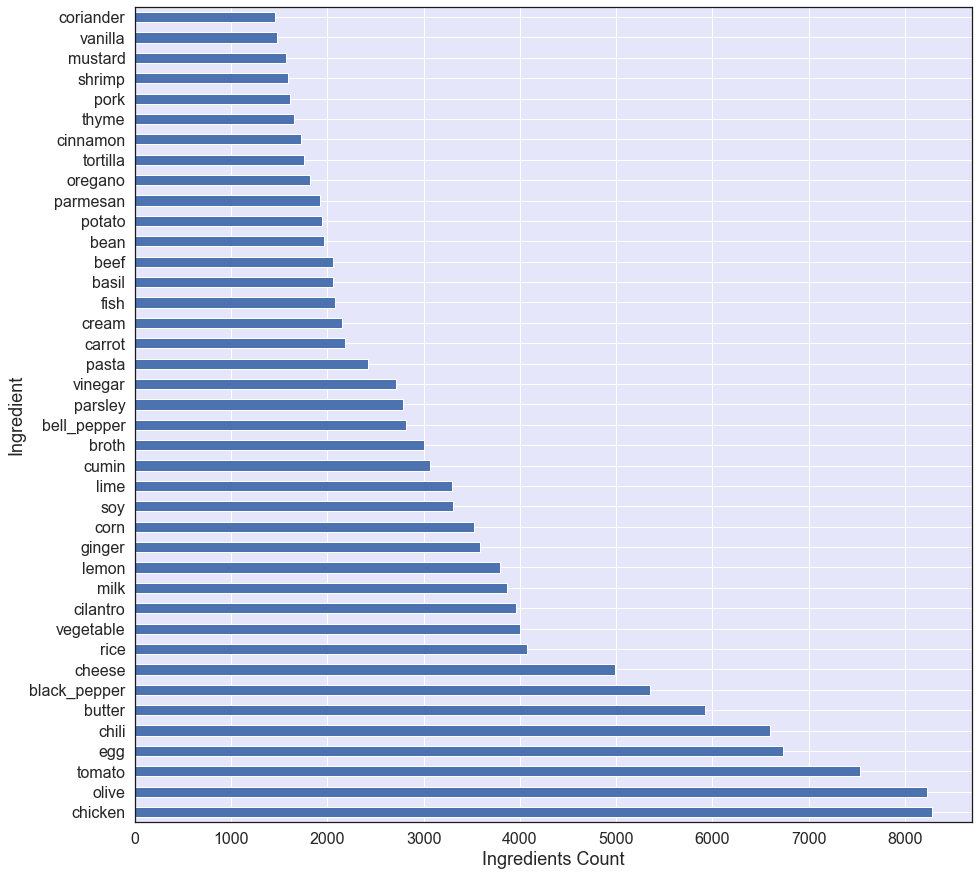

In [23]:
# plot the 40 most frequent words after countvectorization 

cv_dist = pd.DataFrame(X_tr_cvec.todense(), columns=cvec.get_feature_names())
sns.set_style(rc={'axes.facecolor':'lavender', 'figure.facecolor':'w'})
cv_dist.sum().sort_values(ascending=False).head(40).plot(kind='barh', figsize=(15,15))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Ingredients Count',fontsize=18)
plt.ylabel('Ingredient',fontsize=18)
for pos in ['top', 'bottom', 'right', 'left']:
    plt.gca().spines[pos].set_edgecolor('k');

In [25]:
# defining feature and target variables

X = df[['text', 'No_of_ings']] 
y = df['cuisine'].map(dct)

In [26]:
X.shape, y.shape

((39774, 2), (39774,))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [28]:
X_train.shape, X_test.shape

((26648, 2), (13126, 2))

In [29]:
# create a list of custom stopwords and add them to the imported ENGLISH_STOP_WORDS library
my_words = stop_words(x=True)
stop_words_custom = text.ENGLISH_STOP_WORDS.union(my_words)

In [30]:
# instantiate CountVectorizer with a lemmatizer and stopwords

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

    
cvec = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words=stop_words_custom, max_features=600, \
                       min_df=2, max_df=0.99, strip_accents = 'unicode', lowercase = True)  

In [31]:
# create a bag of words using CountVectorizer

X_tr_cvec = cvec.fit_transform(X_train['text'])
X_tst_cvec = cvec.transform(X_test['text'])

df_X_tr_cvec = pd.DataFrame(X_tr_cvec.todense(), columns=cvec.get_feature_names())
df_X_tst_cvec = pd.DataFrame(X_tst_cvec.todense(), columns=cvec.get_feature_names())

In [32]:
df_X_tr_cvec.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
df_X_tst_cvec.reset_index(drop=True, inplace = True)
X_test.reset_index(drop=True, inplace=True)

In [33]:
# concatenating No_of_ings as one of the features
X_tr_cvec_all = pd.concat([df_X_tr_cvec, X_train[['No_of_ings']]], axis=1)
X_tst_cvec_all = pd.concat([df_X_tst_cvec, X_test[['No_of_ings']]], axis=1)

In [34]:
X_tr_cvec_all.shape, X_tst_cvec_all.shape, y_train.shape, y_test.shape

((26648, 601), (13126, 601), (26648,), (13126,))

In [35]:
# normalizing features

sc = StandardScaler()
X_tr_cvec_all_scaled = pd.DataFrame(sc.fit_transform(X_tr_cvec_all),columns = X_tr_cvec_all.columns)
X_tst_cvec_all_scaled = pd.DataFrame(sc.transform(X_tst_cvec_all),columns = X_tst_cvec_all.columns)

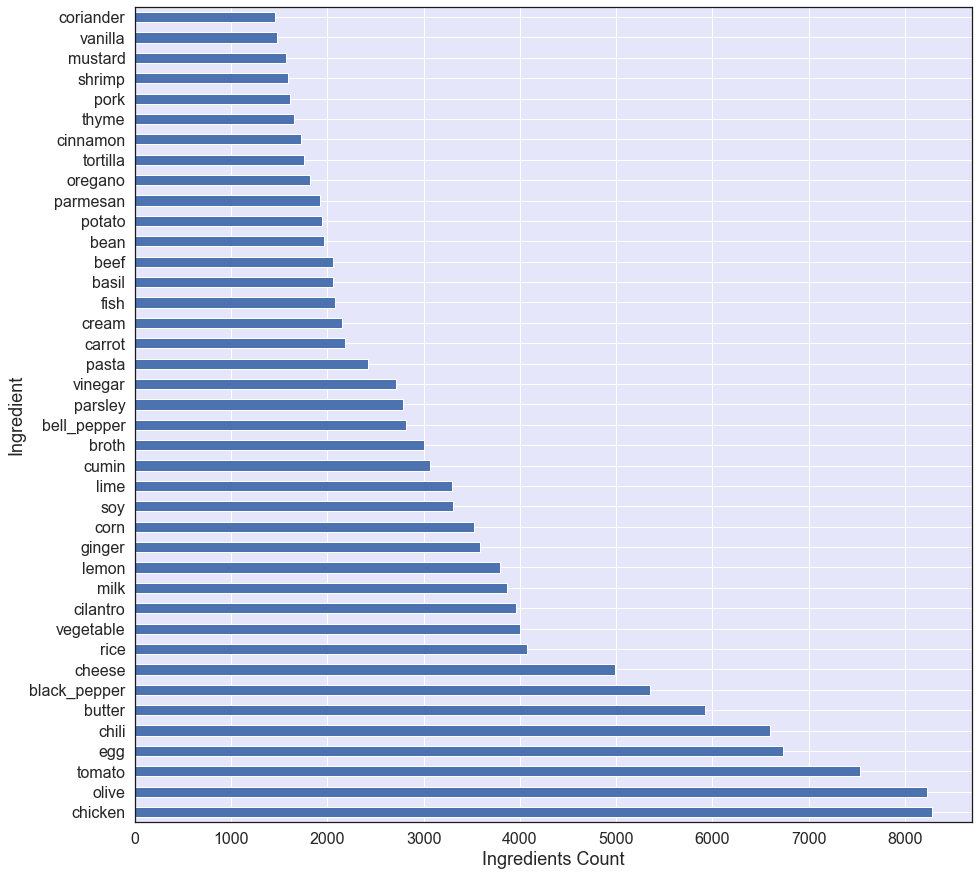

In [36]:
# plot the 40 most frequent words after countvectorization 

cv_dist = pd.DataFrame(X_tr_cvec.todense(), columns=cvec.get_feature_names())
sns.set_style(rc={'axes.facecolor':'lavender', 'figure.facecolor':'w'})
cv_dist.sum().sort_values(ascending=False).head(40).plot(kind='barh', figsize=(15,15))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Ingredients Count',fontsize=18)
plt.ylabel('Ingredient',fontsize=18)
for pos in ['top', 'bottom', 'right', 'left']:
    plt.gca().spines[pos].set_edgecolor('k');

## 4. Modeling

### 4.1 Logistic Regression

In [37]:
# instantiate logreg model

logreg_cvec = LogisticRegression(max_iter=100000, C=0.01)
logreg_cvec.fit(X_tr_cvec_all_scaled, y_train)

LogisticRegression(C=0.01, max_iter=100000)

In [38]:
# report train and test scores

logreg_cvec.score(X_tr_cvec_all_scaled, y_train), logreg_cvec.score(X_tst_cvec_all_scaled, y_test)

(0.7844115881116782, 0.7472192594849916)

In [39]:
# generate predictions and print a classification report

clf_rep_names = df['cuisine'].value_counts().index
y_pred = logreg_cvec.predict(X_tst_cvec_all_scaled)
print(classification_report(y_test, y_pred, target_names=clf_rep_names))

              precision    recall  f1-score   support

     italian       0.76      0.88      0.81      2587
     mexican       0.87      0.92      0.89      2125
 southern_us       0.63      0.77      0.70      1426
      indian       0.84      0.87      0.86       991
     chinese       0.75      0.81      0.78       882
      french       0.54      0.57      0.56       873
cajun_creole       0.80      0.63      0.71       510
        thai       0.75      0.72      0.73       508
    japanese       0.80      0.67      0.73       470
       greek       0.80      0.66      0.72       388
     spanish       0.65      0.44      0.52       326
      korean       0.79      0.64      0.71       274
  vietnamese       0.64      0.50      0.56       272
    moroccan       0.84      0.70      0.76       271
     british       0.52      0.30      0.38       265
    filipino       0.65      0.44      0.53       249
       irish       0.59      0.39      0.47       220
    jamaican       0.82    

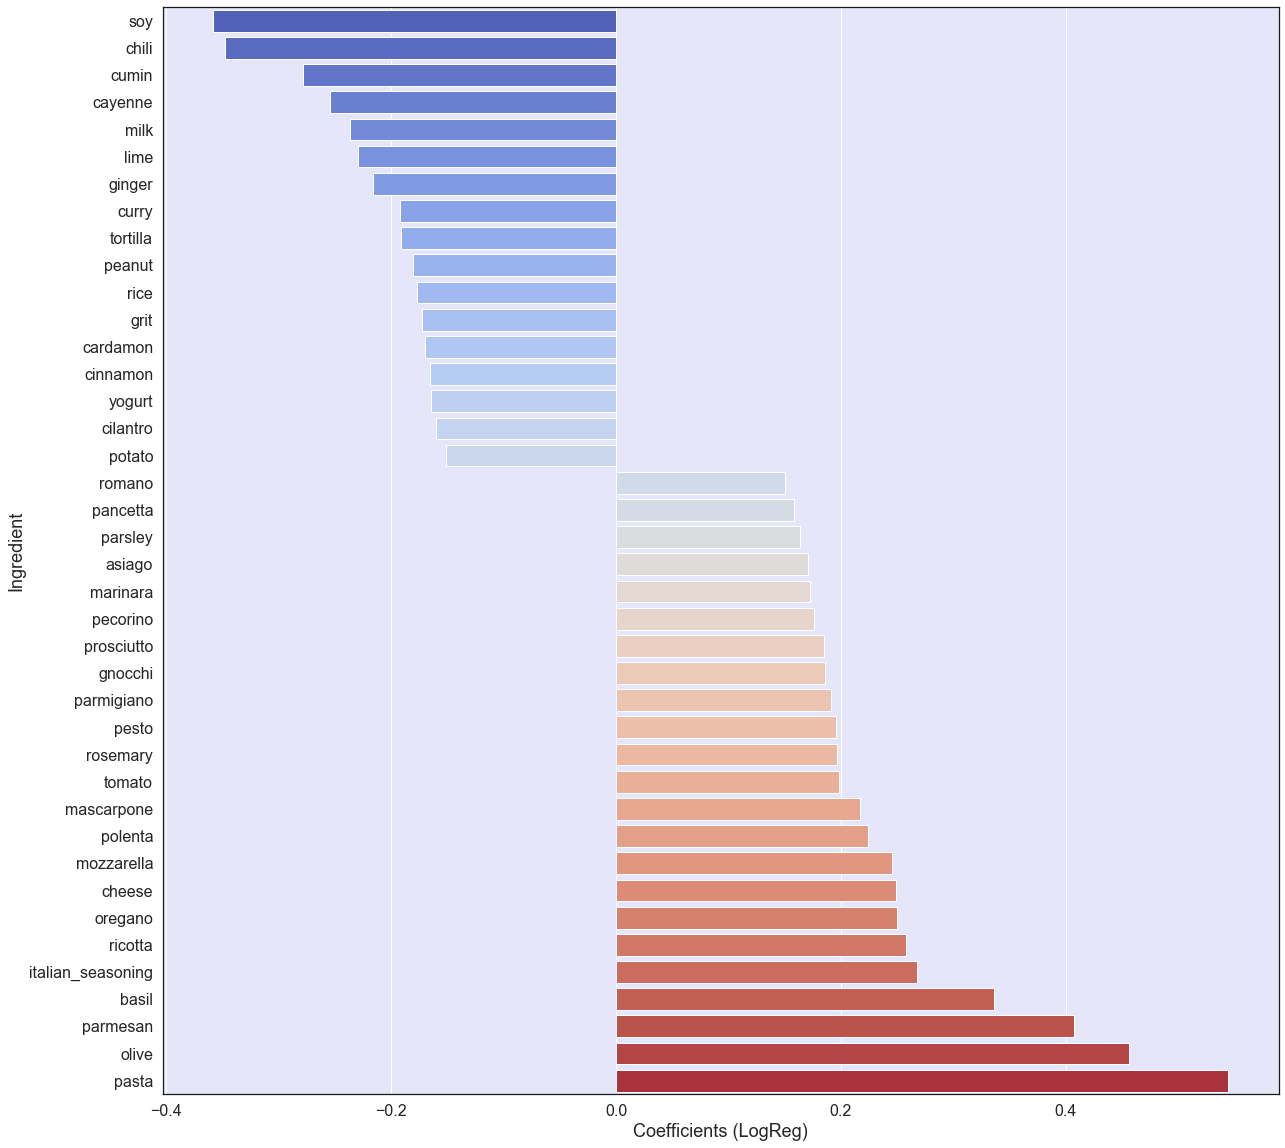

In [40]:
word_feature = pd.DataFrame(
    {'ingredient': X_tr_cvec_all_scaled,
     'coefficient': logreg_cvec.coef_[0].tolist(),
    })
coef = []
cols = []
for item in abs(word_feature.coefficient).nlargest(40).index.tolist():
    coef.append(word_feature.coefficient[item])
    cols.append(X_tr_cvec_all_scaled.columns.tolist()[item])

fig, ax= plt.subplots(figsize=(20, 20), facecolor='w', edgecolor='k')
sns.set(rc={'axes.facecolor':'lavender', 'figure.facecolor':'k'})

ridge_coeff_dict = {y:x for x,y in zip(coef,cols)}
ridge_coeff_dict_sorted = dict(sorted(ridge_coeff_dict.items(), key=lambda item: item[1]))

xx = list(ridge_coeff_dict_sorted.keys())
yy = list(ridge_coeff_dict_sorted.values())

sns.barplot(x=yy, y=xx, palette="coolwarm");
ax.set_xlabel('Coefficients (LogReg)',fontsize=18)
ax.set_ylabel('Ingredient',fontsize=18)
ax.tick_params(labelsize=16)
for pos in ['top', 'bottom', 'right', 'left']:
    ax.spines[pos].set_edgecolor('k')

### 4.2 Random Forest

In [41]:
# instantiate RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_estimators=500, min_samples_split=2, max_depth=16, \
                            min_samples_leaf=5)
rf.fit(X_tr_cvec_all_scaled, y_train)

y_pred = rf.predict(X_tst_cvec_all_scaled)
print(classification_report(y_test, y_pred, target_names=clf_rep_names))

              precision    recall  f1-score   support

     italian       0.57      0.88      0.70      2587
     mexican       0.74      0.90      0.81      2125
 southern_us       0.35      0.73      0.48      1426
      indian       0.77      0.83      0.80       991
     chinese       0.59      0.82      0.69       882
      french       0.75      0.02      0.03       873
cajun_creole       0.88      0.39      0.54       510
        thai       0.73      0.71      0.72       508
    japanese       0.89      0.46      0.61       470
       greek       0.92      0.35      0.51       388
     spanish       1.00      0.02      0.04       326
      korean       0.97      0.13      0.23       274
  vietnamese       0.91      0.15      0.25       272
    moroccan       0.97      0.35      0.51       271
     british       0.00      0.00      0.00       265
    filipino       1.00      0.02      0.05       249
       irish       0.00      0.00      0.00       220
    jamaican       1.00    

In [42]:
# report train and test scores

rf.score(X_tr_cvec_all_scaled, y_train), rf.score(X_tst_cvec_all_scaled, y_test)

(0.6158435905133594, 0.6038397074508609)

### 4.3 KNN

In [43]:
# instantiate KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 13)

knn.fit(X_tr_cvec_all_scaled, y_train)

y_pred = knn.predict(X_tst_cvec_all_scaled)
print(classification_report(y_test, y_pred, target_names=clf_rep_names))

              precision    recall  f1-score   support

     italian       0.62      0.84      0.72      2587
     mexican       0.80      0.81      0.81      2125
 southern_us       0.56      0.68      0.62      1426
      indian       0.74      0.75      0.74       991
     chinese       0.60      0.66      0.63       882
      french       0.46      0.44      0.45       873
cajun_creole       0.76      0.57      0.65       510
        thai       0.74      0.48      0.58       508
    japanese       0.74      0.62      0.68       470
       greek       0.66      0.51      0.58       388
     spanish       0.56      0.28      0.37       326
      korean       0.51      0.51      0.51       274
  vietnamese       0.59      0.38      0.46       272
    moroccan       0.65      0.45      0.54       271
     british       0.45      0.28      0.34       265
    filipino       0.50      0.33      0.40       249
       irish       0.52      0.35      0.41       220
    jamaican       0.70    

In [44]:
# report train and test scores

knn.score(X_tr_cvec_all_scaled, y_train), knn.score(X_tst_cvec_all_scaled, y_test)

(0.6864305013509456, 0.6446746914520799)

### 4.3 SVM

In [45]:
# instantiate SVC

svc = SVC(gamma='auto')

svc.fit(X_tr_cvec_all_scaled, y_train)

y_pred = svc.predict(X_tst_cvec_all_scaled)
print(classification_report(y_test, y_pred, target_names=clf_rep_names))

              precision    recall  f1-score   support

     italian       0.68      0.87      0.76      2587
     mexican       0.86      0.89      0.87      2125
 southern_us       0.57      0.77      0.66      1426
      indian       0.84      0.85      0.84       991
     chinese       0.71      0.77      0.74       882
      french       0.51      0.53      0.52       873
cajun_creole       0.79      0.63      0.70       510
        thai       0.75      0.68      0.72       508
    japanese       0.84      0.63      0.72       470
       greek       0.77      0.57      0.65       388
     spanish       0.69      0.33      0.45       326
      korean       0.79      0.53      0.63       274
  vietnamese       0.67      0.40      0.50       272
    moroccan       0.87      0.64      0.74       271
     british       0.53      0.22      0.31       265
    filipino       0.68      0.35      0.47       249
       irish       0.66      0.28      0.39       220
    jamaican       0.84    

In [46]:
# report train and test scores

svc.score(X_tr_cvec_all_scaled, y_train), svc.score(X_tst_cvec_all_scaled, y_test)

(0.8021615130591414, 0.7122504952003657)

### 4.4 Neural Network

In [47]:
n_input = X_tst_cvec_all_scaled.shape[1] 

model = Sequential()
model.add(Dense(n_input, input_shape = (n_input,), activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(y_train_NN.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2, mode='auto')

In [48]:
history = model.fit(X_tr_cvec_all_scaled, y_train_NN, \
                validation_data=(X_tst_cvec_all_scaled, y_test_NN), epochs=200, \
                    batch_size=512, verbose=2, callbacks=[early_stop])

Epoch 1/200
53/53 - 1s - loss: 5.5779 - accuracy: 0.5884 - val_loss: 3.0595 - val_accuracy: 0.7116
Epoch 2/200
53/53 - 0s - loss: 2.2590 - accuracy: 0.7277 - val_loss: 1.7813 - val_accuracy: 0.7296
Epoch 3/200
53/53 - 0s - loss: 1.5391 - accuracy: 0.7414 - val_loss: 1.4306 - val_accuracy: 0.7342
Epoch 4/200
53/53 - 0s - loss: 1.3160 - accuracy: 0.7446 - val_loss: 1.3015 - val_accuracy: 0.7339
Epoch 5/200
53/53 - 0s - loss: 1.2270 - accuracy: 0.7472 - val_loss: 1.2436 - val_accuracy: 0.7351
Epoch 6/200
53/53 - 0s - loss: 1.1802 - accuracy: 0.7462 - val_loss: 1.2124 - val_accuracy: 0.7369
Epoch 7/200
53/53 - 0s - loss: 1.1598 - accuracy: 0.7466 - val_loss: 1.1935 - val_accuracy: 0.7356
Epoch 8/200
53/53 - 0s - loss: 1.1450 - accuracy: 0.7449 - val_loss: 1.1854 - val_accuracy: 0.7374
Epoch 9/200
53/53 - 0s - loss: 1.1303 - accuracy: 0.7476 - val_loss: 1.1752 - val_accuracy: 0.7366
Epoch 10/200
53/53 - 0s - loss: 1.1195 - accuracy: 0.7477 - val_loss: 1.1666 - val_accuracy: 0.7359
Epoch 11/

In [49]:
y_pred = model.predict(X_tst_cvec_all_scaled)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_test_NN, axis = 1)
print(classification_report(true_categories, predicted_categories, target_names=clf_rep_names))

              precision    recall  f1-score   support

     italian       0.82      0.84      0.83      2587
     mexican       0.80      0.94      0.87      2125
 southern_us       0.72      0.70      0.71      1426
      indian       0.82      0.88      0.85       991
     chinese       0.73      0.83      0.77       882
      french       0.50      0.65      0.57       873
cajun_creole       0.76      0.69      0.73       510
        thai       0.78      0.69      0.73       508
    japanese       0.83      0.66      0.73       470
       greek       0.78      0.68      0.73       388
     spanish       0.58      0.45      0.51       326
      korean       0.72      0.65      0.68       274
  vietnamese       0.67      0.47      0.55       272
    moroccan       0.77      0.75      0.76       271
     british       0.51      0.34      0.41       265
    filipino       0.51      0.50      0.51       249
       irish       0.69      0.31      0.43       220
    jamaican       0.82    